In [1]:
# import de nodige packages
import pandas as pd
import numpy as np
import re 
import os
import sys
import networkx as nx
import math
from collections import defaultdict
import torch
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt

import rdkit
from rdkit import Chem
import rdkit.Chem.AllChem
import rdkit.Chem.Draw
import rdkit.Chem.rdmolfiles
from rdkit.Chem.rdmolfiles import  MolFromXYZFile
from rdkit.Chem import AllChem



# Load the data and couple the SMILES to the yields and remove nan's

In [2]:
# --- 1. Bestanden inlezen als ruwe tekst ---
yields_path = "data/compounds_yield.csv"
smiles_path = "data/compounds_smiles.csv"

# --- 2. Parser voor yields: hoogste percentage extraheren ---
yield_data = []
with open(yields_path, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split(" ", 1)
        if len(parts) == 2:
            compound_id, yield_info = parts
            percentages = re.findall(r'(\d+)%', yield_info)
            if percentages:
                max_yield = max(map(int, percentages))
                yield_data.append((compound_id, str(max_yield)))

df_yields_clean = pd.DataFrame(yield_data, columns=["compound_id", "yield"])

# --- 3. Parser voor SMILES ---
smiles_data = []
with open(smiles_path, "r") as f:
    for line in f:
        parts = [p.strip() for p in line.strip().split(",")]
        if len(parts) == 4:
            compound_id, smiles_raw, number, _ = parts  # ignore smiles_normalized
            smiles_data.append((compound_id, smiles_raw, number))

df_smiles_clean = pd.DataFrame(
    smiles_data,
    columns=["compound_id", "smiles_raw", "some_number"]
)

# --- 4. Merge op compound_id ---
df_merged = pd.merge(df_smiles_clean, df_yields_clean, on="compound_id", how="inner")

print("Merged DataFrame:")
print(df_merged)


Merged DataFrame:
   compound_id                                        smiles_raw some_number  \
0        comp1                            C1C2=C(N=C(O2)C)C=CC=1           1   
1        comp2                        C1C2=C(N=C(O2)C)C=C(Br)C=1          11   
2        comp3                            C1C2=C(N=C(N2)C)C=CC=1           2   
3        comp4                          C1(Cl)=CC=NC2NC(C)=CC1=2          10   
4        comp5                        C1C2=C(N=C(O2)C)C=C(OC)C=1           1   
..         ...                                               ...         ...   
78      comp88  C1C=CC=C2N(C(=O)OC(C)(C)C)C=C([Si]([H])(C)C)C=12           1   
79      comp91                                    C1=CC(F)=NC=C1           1   
80      comp92                                    C1=CC(F)=NC=C1           2   
81      comp93                                    C1=CC(F)=NC=C1           7   
82      comp97                           N1=CC=C(C(F)(F)F)C=C1Cl           2   

   yield  
0     68  

Convert the SMILES to Graphs

In [7]:
"This Class makes a graph out of SMILES and it gives a bond order to it"

ATOM_NUMBERS = {
    "H": 1, "C": 6, "N": 7, "O": 8, "Br": 35, "S": 16
}

BOND_ORDER_MAP = {
    Chem.rdchem.BondType.SINGLE: 1,
    Chem.rdchem.BondType.DOUBLE: 2,
    Chem.rdchem.BondType.TRIPLE: 3,
    Chem.rdchem.BondType.AROMATIC: 1.5,
}

class MolecularGraphFromSMILES:
    def __init__(self, smiles: str):
        self.smiles = smiles
        self.mol = Chem.MolFromSmiles(smiles)
        #self.mol = Chem.AddHs(self.mol)
        self.atoms = [atom.GetSymbol() for atom in self.mol.GetAtoms()]
        self.bonds = [(bond.GetBeginAtomIdx(),
                       bond.GetEndAtomIdx(),
                       BOND_ORDER_MAP.get(bond.GetBondType(), 1))
                      for bond in self.mol.GetBonds()]

    def to_pyg_data(self) -> Data:
        # Node features: atomic number
        x = torch.tensor([[ATOM_NUMBERS[el]] for el in self.atoms], dtype=torch.long)

        # Edge index and edge attributes
        edge_index = []
        edge_attr = []
        for i, j, order in self.bonds:
            edge_index.append([i, j])
            edge_index.append([j, i])
            edge_attr.append([order])
            edge_attr.append([order])

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)

        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

    def visualize(self, with_labels=True):
        G = nx.Graph()
        for i, el in enumerate(self.atoms):
            G.add_node(i, label=el)

        for i, j, order in self.bonds:
            G.add_edge(i, j, label=str(order))

        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=with_labels,
                labels=nx.get_node_attributes(G, 'label'),
                node_color='lightgreen', node_size=700, font_size=10)

        edge_labels = nx.get_edge_attributes(G, 'label')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        plt.show()

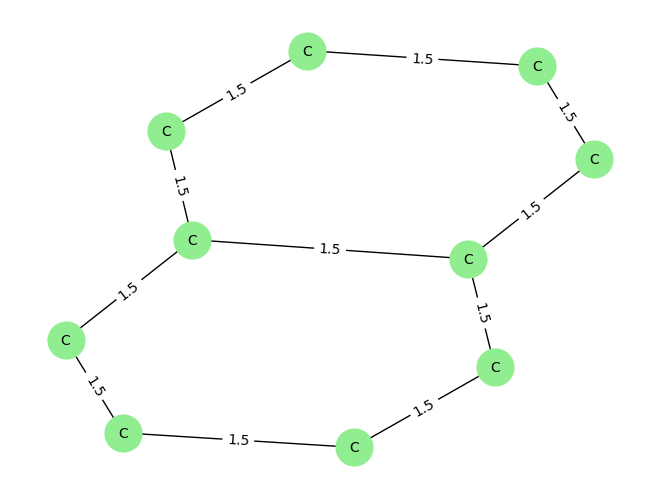

Data(x=[10, 1], edge_index=[2, 22], edge_attr=[22, 1])


In [8]:
# Create a molecule from a SMILES string
smiles = "c1c2ccccc2ccc1"  
mol_graph = MolecularGraphFromSMILES(smiles)

# Visualize the molecule with bond orders
mol_graph.visualize()

# Convert to PyTorch Geometric format
pyg_data = mol_graph.to_pyg_data()
print(pyg_data)